In [50]:
import ee
ee.Initialize()

import geemap
import pandas as pd
import geopandas as gpd
import numpy as np 

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

pd.options.display.float_format = '{:.3f}'.format

## 1 - input parameters

In [51]:
ISO = 'CMR'

In [52]:
classified_image = ee.Image('projects/ee-cocoacmr/assets/outputs/CMR_LC_2020')
tnt_image = ee.Image('projects/ee-cocoacmr/assets/outputs/CMR_TNTMMU_2020')
#classified_image = ee.Image('projects/ee-cocoacmr/assets/outputs/CMR_GIEC_v10')
#classified_image = ee.Image('projects/ee-cocoacmr/assets/outputs/CMR_TNTMMU_2020_v26')

In [53]:
# resolution of the map
scale = 10

In [54]:
# band name for classification
map_band = 'classification'
tnt_band = 'FNF_2020'
#map_band = 'FNF_2020'
#map_band = 'remapped'

In [55]:
# list of class codes
labels = [11,12,13,14,15,21,22,30,41,42,50,60]
#labels = [10,20,30,40,50,60]
#labels = [0,1]

In [56]:
# CEO data
interpretedData = pd.read_csv('/home/sepal-user/COCAFORI/CMR_LC_validated.csv', low_memory=False)
interpretedData.columns

Index(['index', 'plotid', 'sampleid', 'sample_internal_id', 'lon', 'lat',
       'flagged', 'collection_time', 'sample_geom', 'pl_index', 'pl_jrcmap',
       'pl_tcc', 'IPCC_Ref', 'FType_2020_Ref', 'AgType_2020_Ref',
       'HumType_2020_Ref', 'collection', 'interpreted', 'IPCC_2020_Code_Ref',
       'FNF_2020_Ref', 'FType_2020_Code_Ref', 'AgType_2020_Code_Ref',
       'HumType_2020_Code_Ref', 'LC_2020_Code_Ref'],
      dtype='object')

In [57]:
len(interpretedData)

2417

In [58]:
# column with LC code
ref_column = 'LC_2020_Code_Ref'
#ref_column = 'GIEC_2020_Code_Ref'
#ref_column = 'FNF_2020_Ref'

In [59]:
# name out class area outputs file
#area_out = '/home/sepal-user/COCAFORI/CMR_2020_GIEC_types_areas.csv'
area_out = '/home/sepal-user/COCAFORI/CMR_2020_LC_types_areas.csv'

In [60]:
#name of output file with reference and map data
#table_out = '/home/sepal-user/COCAFORI/CMR_2020_GIEC_types_ceo.csv'
table_out = '/home/sepal-user/COCAFORI/CMR_2020_LC_types_ceo.csv'

In [61]:
#name of output error matrix
#matrix_out = '/home/sepal-user/COCAFORI/CMR_2020_LC_types_ref_val_matrix.csv'

### 2 - Get map areas

In [62]:
aoi = ee.FeatureCollection('projects/ee-cocoacmr/assets/admin/cmr_admbnda_adm0')

In [63]:
# Add the area for each pixel
pixelArea = ee.Image.pixelArea().clip(aoi)
# Multiply pixel area by the class to get the area per class
area_image = pixelArea.addBands(classified_image)

In [64]:
# Reduce the region by summing up the areas per class
class_areas = area_image.reduceRegion(
    reducer=ee.Reducer.sum().group(groupField=1, groupName='class'),
    geometry=classified_image.geometry(),
    scale=30,  # Adjust scale according to your image resolution
    maxPixels=1e12
)

In [65]:
# Assuming class_areas is already defined and contains the necessary data
class_areas_dict = class_areas.getInfo()

# Prepare the data for the DataFrame
data = []
for item in class_areas_dict['groups']:
    area_ha = item['sum'] / 10000  # Convert square meters to hectares
    data.append({
        'Class': item['class'],
        'Area (ha)': area_ha
    })

# Convert the list of dictionaries to a DataFrame
areas_df = pd.DataFrame(data)

# Display the DataFrame
print(areas_df)

    Class    Area (ha)
0      11 28403233.699
1      12  2742752.498
2      13   885915.208
3      14   215783.150
4      15  1709811.708
5      21   129177.988
6      22  3567665.134
7      30  6740626.276
8      41   459701.718
9      42   348718.992
10     50   239969.614
11     60  1144214.324


### 3 - sample map with validation points 

In [66]:
gdf = gpd.GeoDataFrame(interpretedData[['index', 'plotid', 'sampleid', 'collection', 'FNF_2020_Ref',ref_column, 'lon', 'lat']], geometry=gpd.points_from_xy(interpretedData.lon, interpretedData.lat), crs='epsg:4326')
gdf

,index,plotid,sampleid,collection,FNF_2020_Ref,LC_2020_Code_Ref,lon,lat,geometry
0,0,4,4,1,1,12,14.299,7.777,POINT (14.29857 7.77672)
1,1,2,2,1,0,30,13.157,9.445,POINT (13.15682 9.44489)
2,2,6,6,1,0,30,13.760,8.647,POINT (13.75959 8.64718)
3,3,7,7,1,0,30,14.741,11.144,POINT (14.74055 11.1445)
4,4,8,8,1,1,11,13.101,4.403,POINT (13.10112 4.40264)
...,...,...,...,...,...,...,...,...,...
2412,2412,1994,1994,6,0,22,14.563,11.449,POINT (14.5629 11.44925)
2413,2413,1927,1927,6,0,22,13.865,10.371,POINT (13.86491 10.37083)
2414,2414,1985,1985,6,0,22,13.137,9.016,POINT (13.13737 9.01635)
2415,2415,1920,1920,6,1,15,11.046,4.097,POINT (11.04591 4.09708)


##### be patient this can take a while with a large number of points

In [67]:
dfs = []
for i in range(0, len(interpretedData), 5000):
    tmp_df = gdf.loc[i:i+4999]
    tmp_fc = geemap.gdf_to_ee(tmp_df[['index','plotid', 'sampleid', 'collection','FNF_2020_Ref', ref_column, 'geometry']])
    tmp_smp = classified_image.select(map_band).reduceRegions(**{
        'collection': tmp_fc,
        'scale': scale,
        'reducer': ee.Reducer.first()   
    })

    tmp_res = geemap.ee_to_gdf(tmp_smp)
    dfs.append(tmp_res)
    
results_df = pd.concat(dfs)

In [68]:
#map_column = 'GIEC_2020_Map'
map_column = 'LC_2020_Code_Map'
#map_column = 'TNT_2020_Map'
results_df = results_df.rename(columns={'first':map_column})
#results_df = results_df.rename(columns={'first': map_column})
results_df

,geometry,FNF_2020_Ref,LC_2020_Code_Ref,collection,LC_2020_Code_Map,index,plotid,sampleid
0,POINT (14.29857 7.77672),1,12,1,11,0,4,4
1,POINT (13.15682 9.44489),0,30,1,30,1,2,2
2,POINT (13.75959 8.64718),0,30,1,30,2,6,6
3,POINT (14.74055 11.1445),0,30,1,30,3,7,7
4,POINT (13.10112 4.40264),1,11,1,11,4,8,8
...,...,...,...,...,...,...,...,...
2412,POINT (14.5629 11.44925),0,22,6,41,2412,1994,1994
2413,POINT (13.86491 10.37083),0,22,6,22,2413,1927,1927
2414,POINT (13.13737 9.01635),0,22,6,22,2414,1985,1985
2415,POINT (11.04591 4.09708),1,15,6,11,2415,1920,1920


In [69]:
dfs1 = []
for i in range(0, len(interpretedData), 5000):
    tmp_df1 = results_df.loc[i:i+4999]
    tmp_fc1 = geemap.gdf_to_ee(tmp_df1[['index', 'plotid', 'sampleid', 'collection','FNF_2020_Ref', 'LC_2020_Code_Ref','LC_2020_Code_Map', 'geometry']])
    
    tmp_smp1 = tnt_image.select(tnt_band).reduceRegions(**{
        'collection': tmp_fc1,
        'scale': scale,
        'reducer': ee.Reducer.first()   
    })

    tmp_res1 = geemap.ee_to_gdf(tmp_smp1)
    dfs1.append(tmp_res1)

results_df2 = pd.concat(dfs1)

In [70]:
results_df = results_df2.rename(columns={'first':'FNF_2020_Map'})
results_df

,geometry,FNF_2020_Ref,LC_2020_Code_Map,LC_2020_Code_Ref,collection,FNF_2020_Map,index,plotid,sampleid
0,POINT (14.29857 7.77672),1,11,12,1,1,0,4,4
1,POINT (13.15682 9.44489),0,30,30,1,0,1,2,2
2,POINT (13.75959 8.64718),0,30,30,1,0,2,6,6
3,POINT (14.74055 11.1445),0,30,30,1,0,3,7,7
4,POINT (13.10112 4.40264),1,11,11,1,1,4,8,8
...,...,...,...,...,...,...,...,...,...
2412,POINT (14.5629 11.44925),0,41,22,6,0,2412,1994,1994
2413,POINT (13.86491 10.37083),0,22,22,6,0,2413,1927,1927
2414,POINT (13.13737 9.01635),0,22,22,6,0,2414,1985,1985
2415,POINT (11.04591 4.09708),1,11,15,6,1,2415,1920,1920


In [71]:
#export table with map and reference
results_df.to_csv(table_out,index=False)

#### Confusion matrix

In [72]:
conf_matrix = confusion_matrix(results_df[ref_column], results_df[map_column], labels=labels)

In [73]:
# Calculate F1 score per class (individual F1 scores for each class)
f1_per_class = f1_score(results_df[ref_column], results_df[map_column], labels=labels, average=None)

# Print F1 score per class
print("F1 score per class:")
for i, class_label in enumerate(labels):
    print(f"Class {class_label}: {f1_per_class[i]:.4f}")

# Optionally, also print the macro and weighted F1 scores
f1_macro = f1_score(results_df[ref_column], results_df[map_column], labels=labels, average='macro')
f1_weighted = f1_score(results_df[ref_column], results_df[map_column], labels=labels, average='weighted')

print(f"\nMacro F1-score: {f1_macro:.4f}")  # Unweighted mean F1-score for all classes
print(f"Weighted F1-score: {f1_weighted:.4f}")  # Weighted by support (number of true instances per class)

F1 score per class:
Class 11: 0.8026
Class 12: 0.2630
Class 13: 0.1120
Class 14: 0.9474
Class 15: 0.5156
Class 21: 0.5714
Class 22: 0.5559
Class 30: 0.6370
Class 41: 0.5000
Class 42: 0.8116
Class 50: 0.7576
Class 60: 0.1071

Macro F1-score: 0.5484
Weighted F1-score: 0.6078


In [74]:
cm_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)
print(cm_df)

     11  12  13  14  15  21   22   30  41  42  50  60
11  754   4   0   0  29   1    4    3   0   0   0   2
12  121  53  17   0   9   1    0   14   1   0   0   2
13   84  41  14   0   4   0    5   32   0   0   0   8
14    0   0   0  18   0   0    0    1   0   0   0   0
15   60   9   0   0  66   1    1    9   0   0   0   0
21    1   0   0   0   1   8    1    4   0   0   0   0
22    2   2   0   0   0   1  102   41   4   0   0   4
30   44  72  29   0   1   1   85  386  12   0   2  68
41    8   0   1   1   0   0    3    5  22   2   0   4
42    0   1   0   0   0   0    1    3   2  28   0   4
50    8   2   1   0   0   0    6   11   1   0  50   1
60    0   1   0   0   0   0    3    3   0   0   0   6


In [75]:
#export
#cm_df.to_csv(matrix_out,index=True)

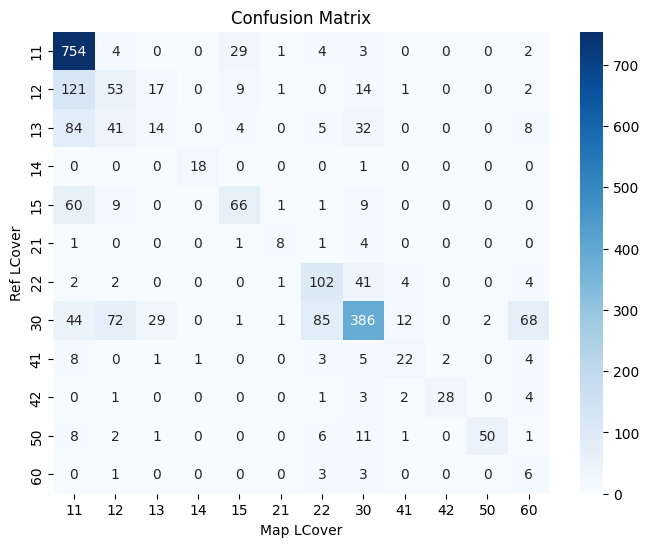

In [76]:
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Ref LCover')
plt.xlabel('Map LCover')
plt.title('Confusion Matrix')
plt.show()

In [77]:
# Select the column from areas_df to use for multiplication, for example, 'Area1'
area_column = areas_df['Area (ha)']

In [78]:
# Convert the selected column to a NumPy array for broadcasting
area_column = area_column.to_numpy()

In [79]:
# Perform element-wise multiplication using broadcasting
weighted_conf_matrix = conf_matrix * area_column[:, np.newaxis]
weighted_conf_matrix

array([[2.14160382e+10, 1.13612935e+08, 0.00000000e+00, 0.00000000e+00,
        8.23693777e+08, 2.84032337e+07, 1.13612935e+08, 8.52097011e+07,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.68064674e+07],
       [3.31873052e+08, 1.45365882e+08, 4.66267925e+07, 0.00000000e+00,
        2.46847725e+07, 2.74275250e+06, 0.00000000e+00, 3.83985350e+07,
        2.74275250e+06, 0.00000000e+00, 0.00000000e+00, 5.48550500e+06],
       [7.44168774e+07, 3.63225235e+07, 1.24028129e+07, 0.00000000e+00,
        3.54366083e+06, 0.00000000e+00, 4.42957604e+06, 2.83492866e+07,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.08732166e+06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.88409670e+06,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.15783150e+05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.02588702e+08, 1.53883054e+07, 0.00000000e+00, 0.00000000e+00,
        1.12847573e+08, 1.70981171e+06, 1.70981171e+06, 1.53

In [80]:
# Calculate overall accuracy
overall_accuracy = np.trace(weighted_conf_matrix) / np.sum(weighted_conf_matrix)
overall_accuracy

0.8515504290347272

In [81]:
# Calculate user's accuracy (precision) and producer's accuracy (recall)
users_accuracy = np.diag(weighted_conf_matrix) / np.sum(weighted_conf_matrix, axis=0)
users_accuracy

array([0.96319535, 0.18055116, 0.04859895, 0.89417057, 0.11614139,
       0.02338195, 0.3422263 , 0.88933419, 0.0928249 , 0.91394202,
       0.47090292, 0.0124292 ])

In [82]:
producers_accuracy = np.diag(weighted_conf_matrix) / np.sum(weighted_conf_matrix, axis=1)
producers_accuracy

array([0.94604768, 0.24311927, 0.07446809, 0.94736842, 0.45205479,
       0.53333333, 0.65384615, 0.55142857, 0.47826087, 0.71794872,
       0.625     , 0.46153846])

In [83]:
# Calculate the kappa coefficient
total_sum = np.sum(weighted_conf_matrix)
random_agreement = np.sum(np.sum(weighted_conf_matrix, axis=0) * np.sum(weighted_conf_matrix, axis=1)) / total_sum
kappa = (overall_accuracy - random_agreement) / (1 - random_agreement)

In [84]:
# Create a DataFrame to display the results
results = {
    "Class": labels,
    "User's Accuracy": users_accuracy,
    "Producer's Accuracy": producers_accuracy,
    "Reference Area": area_column
}

acc_df = pd.DataFrame(results)

# Adding Overall Accuracy and Kappa to the DataFrame
acc_df.loc["Overall Accuracy"] = ["-", overall_accuracy, "-", "-"]
acc_df.loc["Kappa"] = ["-", kappa, "-", "-"]

# Display the results
print(acc_df)

                 Class  User's Accuracy Producer's Accuracy Reference Area
0                   11            0.963               0.946   28403233.699
1                   12            0.181               0.243    2742752.498
2                   13            0.049               0.074     885915.208
3                   14            0.894               0.947     215783.150
4                   15            0.116               0.452    1709811.708
5                   21            0.023               0.533     129177.988
6                   22            0.342               0.654    3567665.134
7                   30            0.889               0.551    6740626.276
8                   41            0.093               0.478     459701.718
9                   42            0.914               0.718     348718.992
10                  50            0.471               0.625     239969.614
11                  60            0.012               0.462    1144214.324
Overall Accuracy     -   

In [85]:
import random

def bootstrap_conf_intervals(data, num_samples=100, alpha=0.05):
    samples = np.random.choice(data, size=(num_samples, len(data)), replace=True)
    metric_means = np.mean(samples, axis=1)
    lower = np.percentile(metric_means, 100 * alpha / 2)
    upper = np.percentile(metric_means, 100 * (1 - alpha / 2))
    return lower, upper

# Compute bootstrap confidence intervals for user's accuracy
user_accuracy_intervals = [bootstrap_conf_intervals(conf_matrix[i, :] / conf_matrix.sum(axis=1)) for i in range(len(conf_matrix))]
producer_accuracy_intervals = [bootstrap_conf_intervals(conf_matrix[:, i] / conf_matrix.sum(axis=0)) for i in range(len(conf_matrix))]
overall_accuracy_interval = bootstrap_conf_intervals([overall_accuracy] * len(conf_matrix))
kappa_interval = bootstrap_conf_intervals([kappa] * len(conf_matrix))

# Compute bootstrap confidence intervals for area calculations
area_intervals = [bootstrap_conf_intervals(areas_df['Area (ha)']) for area in areas_df['Area (ha)']]

In [86]:
results = {
    "Class": labels,
    "User's Accuracy": users_accuracy,
    "User's Accuracy CI": user_accuracy_intervals,
    "Producer's Accuracy": producers_accuracy,
    "Producer's Accuracy CI": producer_accuracy_intervals,
    "Reference Area": areas_df['Area (ha)'],
    "Area CI": area_intervals
}

acc_df = pd.DataFrame(results)

# Adding Overall Accuracy and Kappa to the DataFrame
acc_df.loc["Overall Accuracy"] = ["-", overall_accuracy, overall_accuracy_interval, "-", "-", "-", "-"]
acc_df.loc["Kappa"] = ["-", kappa, kappa_interval, "-", "-", "-", "-"]

# Display the results
acc_df

,Class,User's Accuracy,User's Accuracy CI,Producer's Accuracy,Producer's Accuracy CI,Reference Area,Area CI
0,11,0.963,"(0.01883605627385475, 0.29517771347510957)",0.946,"(0.13199199161853745, 0.5493380306176453)",28403233.699,"(1198052.439106128, 10194103.115973618)"
1,12,0.181,"(0.023361575622445188, 0.11876343934685717)",0.243,"(0.02418195736721609, 0.21564939488063195)",2742752.498,"(1126153.8869297802, 8489704.201744923)"
2,13,0.049,"(0.0256456562697442, 0.2183307236488035)",0.074,"(0.006503858554639804, 0.07017930492925767)",885915.208,"(1064100.4326899748, 8598138.402130282)"
3,14,0.894,"(0.0, 0.3157894736842105)",0.947,"(0.0, 0.2398678989139515)",215783.150,"(895191.7665387562, 8203384.385662342)"
4,15,0.116,"(0.006150330700597326, 0.12128510955865794)",0.452,"(0.010241102324804055, 0.17116546844393052)",1709811.708,"(1055589.9150174204, 7600435.086266749)"
5,21,0.023,"(0.0008946098426179983, 0.13539408923662483)",0.533,"(0.0006610882203400214, 0.15578334422441045)",129177.988,"(1001738.0085121549, 8133257.211720939)"
6,22,0.342,"(0.01486066496135411, 0.2546065307496012)",0.654,"(0.03247564404338001, 0.17168918147796727)",3567665.134,"(979032.6011539948, 10543889.382891092)"
7,30,0.889,"(0.11429845264975183, 1.5400835234708872)",0.551,"(0.10372809020822951, 0.31606845895301666)",6740626.276,"(858391.0873119363, 8777535.518935379)"
8,41,0.093,"(0.011302361053539009, 0.1577326086834642)",0.478,"(0.005007122995357964, 0.1622606340672744)",459701.718,"(1011238.585503308, 7598868.246345595)"
9,42,0.914,"(0.0021649247796036784, 0.22457195356664333)",0.718,"(0.0, 0.23541666666666664)",348718.992,"(940885.4102784225, 8405030.777561687)"
